# Notebook Reference:

1. [Environment Preparation](#ENVPREP)<br/>
1. [Read Temperature Dataset](#READDATA)<br/>
2. [Data Exploration for Raw Data](#DATAEXPL) <br />
3. [Data Cleaning for City Temperature Dataset](#DATACLEAN) <br />
4. [ARIMA Model](#ARIMAMODEL) <br />
5. [Data Preparation and Analyzation for Two Sub-Datasets](#TWOSUBDATA) <br />
6. [Artifical Neural Network Model](#ANN) <br />

# Enviroment Preparation <a id='ENVPREP'></a>

In [1]:
# Regular libraries for Data processing and plotting

import pandas as pd
import numpy as np
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly as py
import plotly.express as px
import plotly.offline as po
import plotly.graph_objs as pg

# Libraries for ARIMA models

from statsmodels.tsa.statespace.sarimax import SARIMAX 
from pmdarima.arima import auto_arima

# Libraries for model evaluation and data prep fpr model

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_percentage_error

# Librarues for ANN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Read Temperature Dataset <a id='READDATA'></a>

In [2]:
df_temp = pd.read_csv("source/GlobalLandTemperaturesByCity.csv")

In [3]:
df_temp.head()

dt  AverageTemperature  AverageTemperatureUncertainty   City  \
0  1743-11-01               6.068                          1.737  Århus   
1  1743-12-01                 NaN                            NaN  Århus   
2  1744-01-01                 NaN                            NaN  Århus   
3  1744-02-01                 NaN                            NaN  Århus   
4  1744-03-01                 NaN                            NaN  Århus   

   Country Latitude Longitude  
0  Denmark   57.05N    10.33E  
1  Denmark   57.05N    10.33E  
2  Denmark   57.05N    10.33E  
3  Denmark   57.05N    10.33E  
4  Denmark   57.05N    10.33E

In [4]:
df_temp.isna().sum()

dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
dtype: int64

In [5]:
df = df_temp.dropna()

# Data Exploration for Raw Data <a id='DATAEXPL'></a>

In [6]:
df.describe()

AverageTemperature  AverageTemperatureUncertainty
count        8.235082e+06                   8.235082e+06
mean         1.672743e+01                   1.028575e+00
std          1.035344e+01                   1.129733e+00
min         -4.270400e+01                   3.400000e-02
25%          1.029900e+01                   3.370000e-01
50%          1.883100e+01                   5.910000e-01
75%          2.521000e+01                   1.349000e+00
max          3.965100e+01                   1.539600e+01

In [7]:
df_country = df[['Country','City','dt','AverageTemperature']].groupby(['Country'])\
                .agg({'AverageTemperature': ['min','max','mean'], 'dt' : ['min','max']})\
                .sort_values(by=[('AverageTemperature', 'mean')])
# print(df_country.to_string())

<Axes: xlabel='Country'>

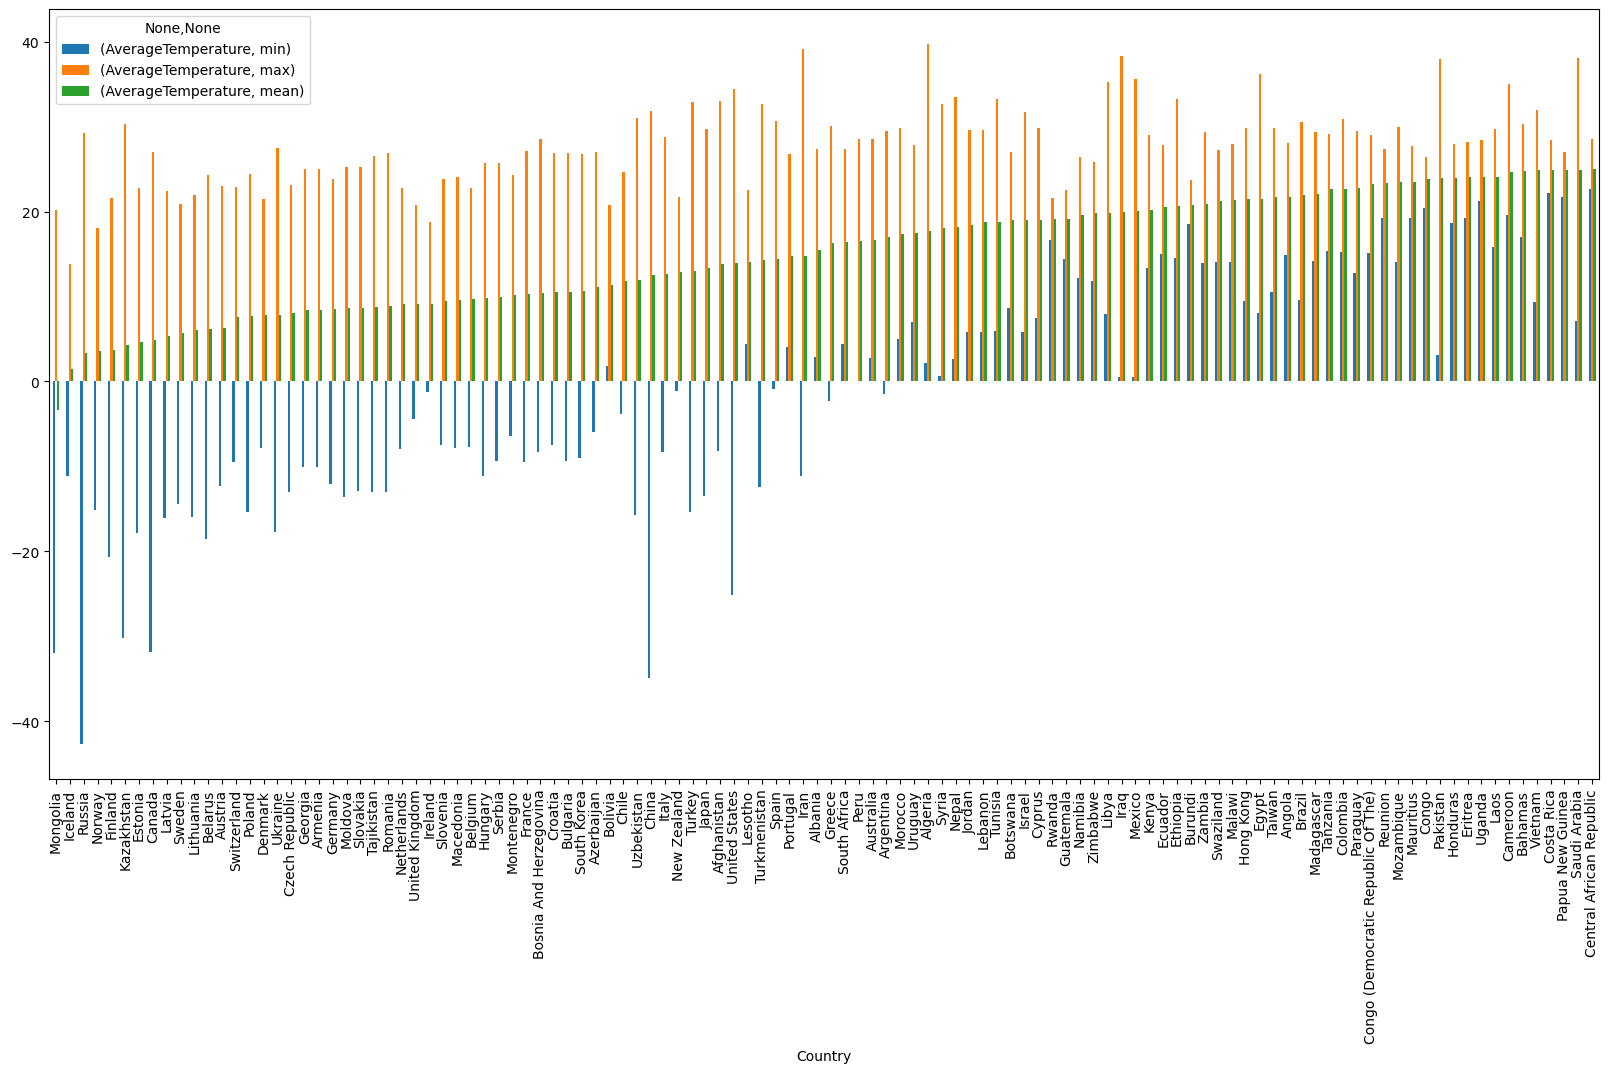

In [8]:
# fig, ax = plt.subplots(figsize=(15,5))
# plt.xticks(rotation=45, ha='right')
# plt.bar(df_country[(df_country[('AverageTemperature', 'mean')] < 10)])
df_country[(df_country[('AverageTemperature', 'mean')] <= 25)].plot.bar(figsize=(20, 10))

<Axes: xlabel='Country'>

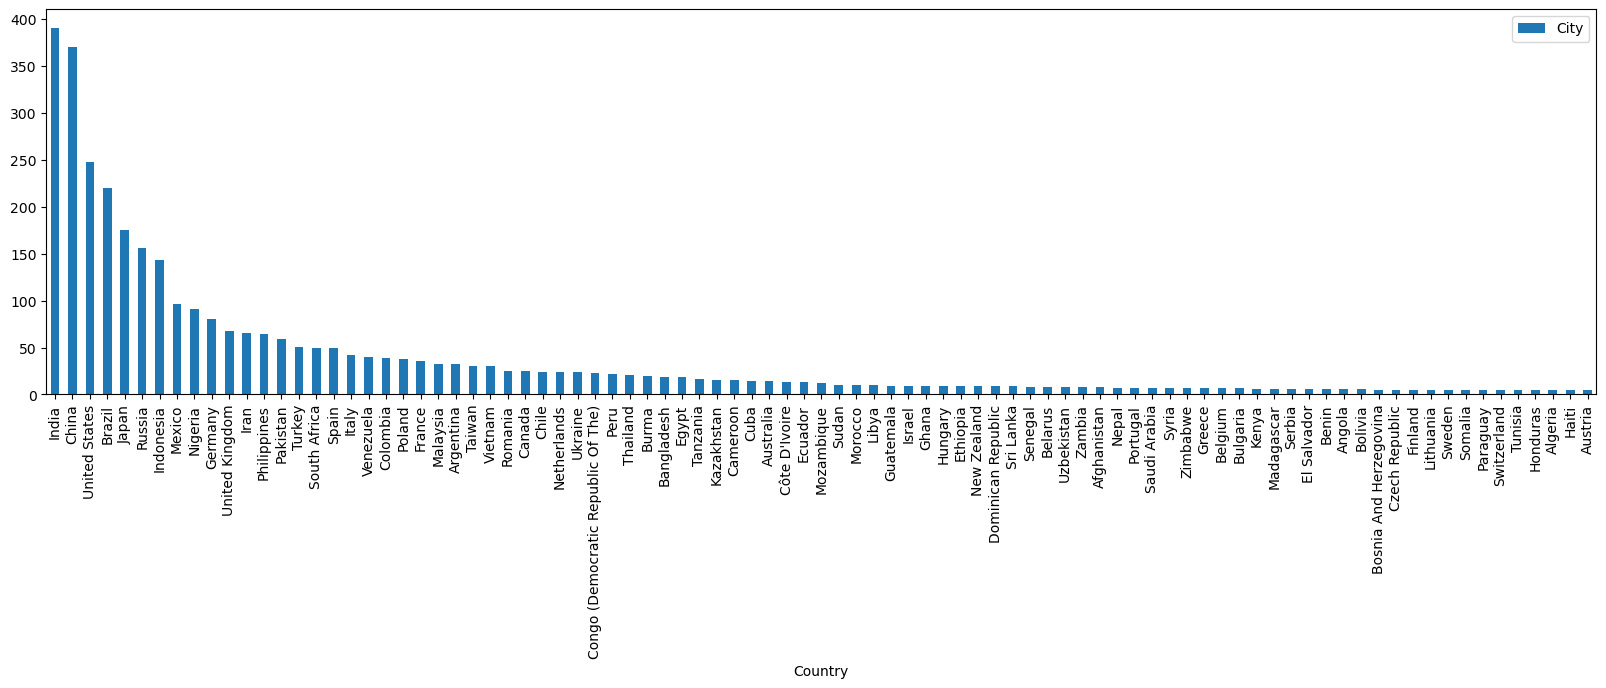

In [9]:
df_city_count = df[['Country','City']].drop_duplicates().groupby(['Country']).count().sort_values(by=['City'],ascending=False)
# print(df_city_count.to_string())
df_city_count[(df_city_count['City'] >= 5)].plot.bar(figsize=(20, 5))

In [10]:
box_countries = df_city_count[(df_city_count['City'] >= 10)].index
# countries = df_country[(df_country[('AverageTemperature', 'mean')] < 15)].index

<Axes: xlabel='Country', ylabel='AverageTemperature'>

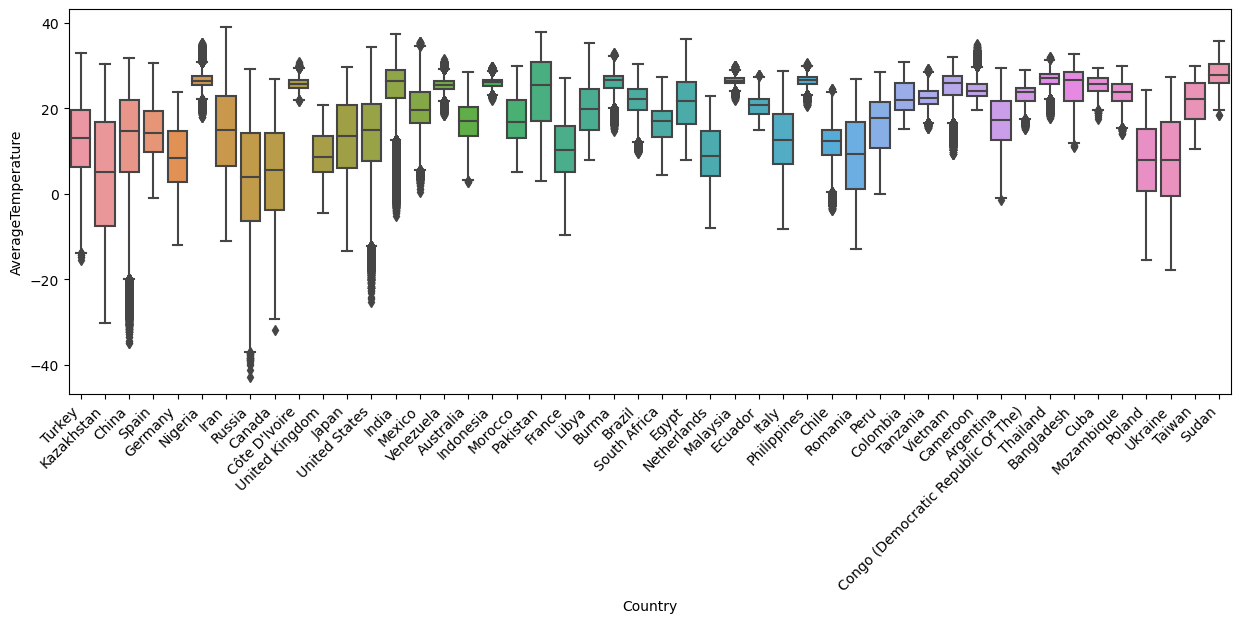

In [11]:
df_box_plt = df[df['Country'].isin(box_countries)]
fig, ax = plt.subplots(figsize=(15,5))
plt.xticks(rotation=45, ha='right')
sns.boxplot(x = df_box_plt['Country'], y = df_box_plt['AverageTemperature'])

In [12]:
box_countries_2 = df_city_count[(df_city_count['City'] < 20) & (df_city_count['City'] >= 5)].index

<Axes: xlabel='Country', ylabel='AverageTemperature'>

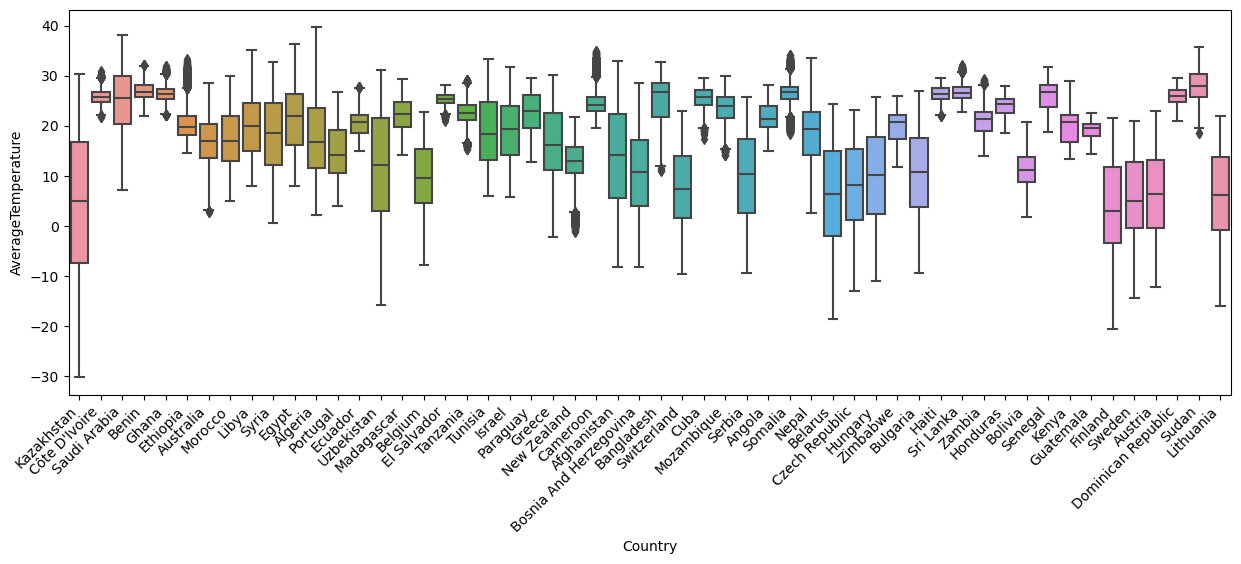

In [13]:
df_box_plt_2 = df[df['Country'].isin(box_countries_2)]
fig, ax = plt.subplots(figsize=(15,5))
plt.xticks(rotation=45, ha='right')
sns.boxplot(x = df_box_plt_2['Country'], y = df_box_plt_2['AverageTemperature'])

## Data Cleaning for City Temperature Dataset <a id='DATACLEAN'></a>

In [14]:
df['year'] = df['dt'].str[:4]

C:\Users\sachi\AppData\Local\Temp\ipykernel_33128\3362832027.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
# Check any city with less than 12 months per year
#####################################################
# 1. Filter the year since 1780
# 2. Get month count for each country, city, year
# 3. Include only cites which have month_count = 12
#####################################################

tmp_city_since = df.loc[df['year'].astype(int) >= 1780]
city_tmp_month_count = tmp_city_since.groupby(['Country','City', 'year']).size().reset_index(name='count')
city_tmp_with_12_month = city_tmp_month_count.loc[city_tmp_month_count['count'] == 12]

print("Count: " + str(city_tmp_with_12_month.count()))


Count: Country    645795
City       645795
year       645795
count      645795
dtype: int64


In [16]:
# Calculate mean of AverageTemperature by country and year
# Prepare the dataset for train and test split

temp_by_city_cleaned = pd.merge(df,city_tmp_with_12_month,on=['Country','City', 'year'])
# temp_by_city_cleaned.rename(columns= {'Country':'temp_country', 'City': 'temp_city', 'Year': 'temp_year', 'AverageTemperature': 'AverageTemperature'}, inplace = True)
tmp_cnty_mean = temp_by_city_cleaned.groupby(['Country','year'])['AverageTemperature'].mean().reset_index().sort_values(by=['year'])
df_mean = tmp_cnty_mean.reset_index(drop=True)

df_mean.head()

Country  year  AverageTemperature
0  Bosnia And Herzegovina  1780           10.549433
1                 Croatia  1780           10.607778
2             Switzerland  1780            7.717683
3                  France  1780           10.658708
4                   Italy  1780           12.959673

In [17]:
# df_mean = df.groupby(['Country','year']).mean()
# df_mean = df_mean.reset_index()

## Data Analyzation for Cleaned Data 

In [18]:
line_countries = df_city_count[(df_city_count['City'] >= 50)].index

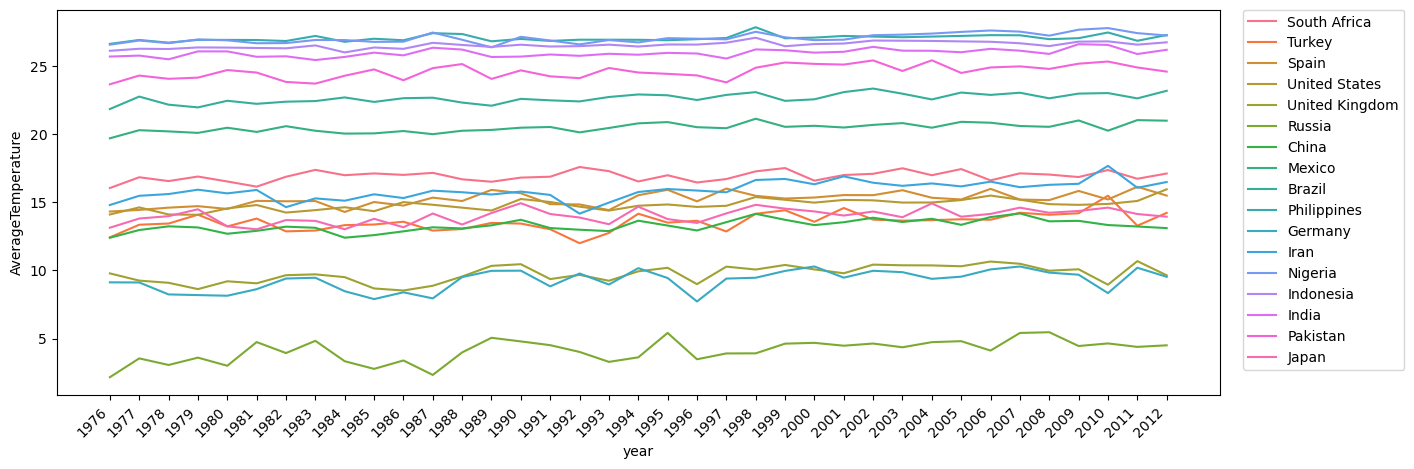

In [19]:
df_line_plt = df_mean[(df_mean['Country'].isin(line_countries)) & (df_mean['year'].astype('int') > 1975) ]
fig, ax = plt.subplots(figsize=(15,5))
plt.xticks(rotation=45, ha='right')
sns.lineplot(x = df_line_plt['year'], y = df_line_plt['AverageTemperature'], hue = df_line_plt['Country'])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

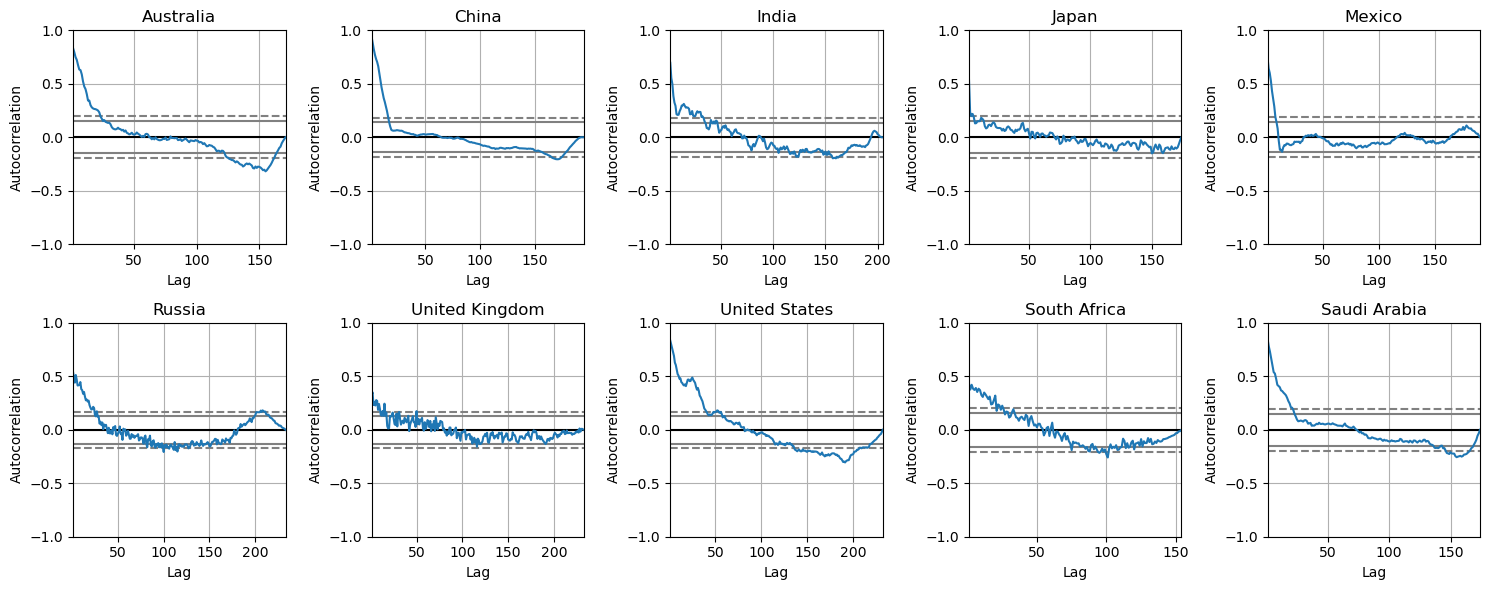

In [20]:
countries = ['Australia','China','India','Japan', 'Mexico','Russia','United Kingdom', 'United States','South Africa','Saudi Arabia']
fig=plt.figure(figsize=(15,6))
for i,country in enumerate(countries):
    ax=fig.add_subplot(2,5,i+1)
    autocorrelation_plot(df_mean[(df_mean['Country'] == country)]['AverageTemperature'])
    ax.set_title(country)
    fig.tight_layout() 

# ARIMA Model: <a id='ARIMAMODEL'></a>

<h3> Using ARIMA model to forecast the temperature </h3>
<ul>
    <li> Dataset: mean of AverageTemperature by country and year </li>
</ul>

In [21]:
df_mean['year'] = df_mean.year.astype(str)

In [22]:
# Function to run ARIMA model

def auto_arima_model(country):
    
    print("ARIMA model for " + country)
    
    #Get the specific country
    df_temp_inv_cntry = df_mean[df_mean["Country"] == country] 
    
    #drop the country column
    df_temp_inv_cntry = df_temp_inv_cntry.drop(columns=['Country'])
    
    # Convert Index to date data type for year
    df_temp_inv_cntry.index = pd.DatetimeIndex(df_temp_inv_cntry.year).to_period('Y')
    
    #split the dataset
    split = int(len(df_temp_inv_cntry) * 0.8)
    train, test = df_temp_inv_cntry[0:split], df_temp_inv_cntry[split:]
    
    #run the model
    arima_model = auto_arima(df_temp_inv_cntry.AverageTemperature, start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = False, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50)  
    
    #store the first table of model summary
    arima_summary = pd.read_html(arima_model.summary().tables[0].as_html(),header=None,index_col=0)[0]
    
    #retrieve the table
    model_val = arima_summary[1].iloc[1]
    
    #Get the order value for SARIMAX
    order_val = model_val[8:15]
    order_val_spl = order_val.split(',')
    order_val_tup = tuple(int(i) for i in order_val_spl)
    
    #Get the seasonal value for SARIMAX
    seasonal_order_val = model_val[18:-1]
    if "[" in seasonal_order_val:
        open_bracket_index = seasonal_order_val.index("[")
        close_bracket_index = seasonal_order_val.index("]")
        seasonal_order_val_1 = seasonal_order_val[:open_bracket_index - 1]
        seasonal_order_val_1_spl = seasonal_order_val_1.split(',')
        p1 = tuple(int(i) for i in seasonal_order_val_1_spl if len(i) > 0)

        seasonal_order_val_2 = seasonal_order_val[open_bracket_index + 1:close_bracket_index]
        seasonal_order_val_2_spl = seasonal_order_val_2.split(',')
        p2 = tuple([[int(i) for i in seasonal_order_val_2_spl if len(i) > 0]])

        seasonal_order_val_3 = seasonal_order_val[close_bracket_index + 1:]
        seasonal_order_val_3_spl = seasonal_order_val_3.split(',')
        p3 = tuple(int(i) for i in seasonal_order_val_3_spl if len(i) > 0)

        seasonal_order_val_tup = p1 + p2 + p3
    else:
        seasonal_order_val_spl = seasonal_order_val.split(',')
        seasonal_order_val_tup = tuple(int(i) for i in seasonal_order_val_spl)
    
    #Run SARIMAX model
    sarimax_model = SARIMAX(train['AverageTemperature'], order = order_val_tup,  seasonal_order =seasonal_order_val_tup)
    
    #Fit the model for ARIMA
    arima_result = sarimax_model.fit(disp=0)
    
    max_year = str(int(df_temp_inv_cntry.year.max()) + 1)
    prediction_period = str(int(max_year) + 30)
    
    #Predict
    train_predict = arima_result.predict(0,len(train)-1)
    test_predict = arima_result.predict(len(train),len(df_temp_inv_cntry)-1)
    future_predict = arima_result.predict(max_year,prediction_period)
    
        
    if(country == 'United States'): 
        #Model evaluation
        train['AverageTemperature'].plot(label = 'Train')
        train_predict.plot(label = 'Train Predict')
        test['AverageTemperature'].plot(label = 'Test')
        test_predict.plot(label = 'Test Predict')
        plt.legend(loc=4)

        residuals = pd.DataFrame(arima_result.resid)
        residuals.plot(label = 'Residual')  
        plt.axhline(0, color="red", linestyle="--")
        residuals.plot(kind='kde', label = 'KDE')
        plt.axvline(0, color="red", linestyle="--")
        plt.show()
        # arima_result.summary

        train_mse = mean_squared_error(pd.Series(train['AverageTemperature']),train_predict)
        test_mse =  mean_squared_error(pd.Series(test['AverageTemperature']),test_predict)

        train_r2 = r2_score(pd.Series(train['AverageTemperature']),train_predict)
        test_r2 =  r2_score(pd.Series(test['AverageTemperature']),test_predict)

        train_mape = mean_absolute_percentage_error(pd.Series(train['AverageTemperature']),train_predict)
        test_mape =  mean_absolute_percentage_error(pd.Series(test['AverageTemperature']),test_predict)
        
        print("MSE for Training Dataset :", train_mse)
        print("MSE for Test Dataset :", test_mse)
        print("R2 for Training Dataset :", train_r2)
        print("R2 for Test Dataset :", test_r2)
        print("MAPE for Training Dataset :", train_mape)
        print("MAPE for Test Dataset :", test_mape)
    
    #history data
    history_data = df_temp_inv_cntry.drop(columns=['year'])
    history_data['Country'] = country
    
    return future_predict, history_data

<h3> Population Selection </h3> 

In [23]:
## All Country

#countries = [i for i in df_merge.Country.unique()]

In [24]:
## a set of Countries

countries = ['United States']

<h3> Run the Model </h3>

ARIMA model for United States


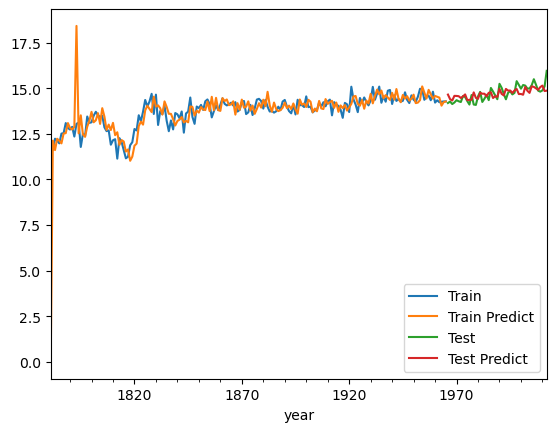

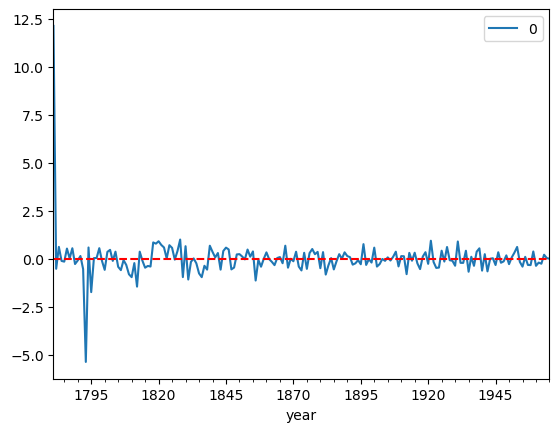

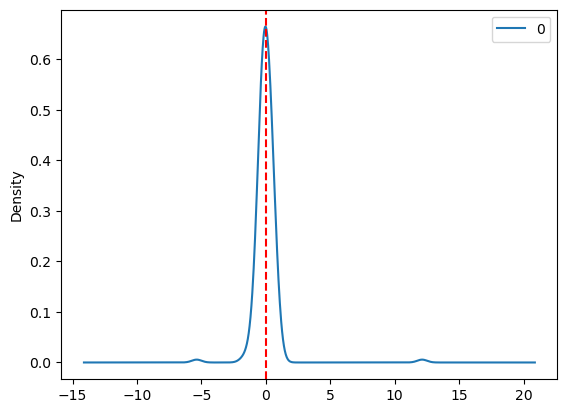

MSE for Training Dataset : 1.1624642628264976
MSE for Test Dataset : 0.1072141581427752
R2 for Training Dataset : -0.6920511949425021
R2 for Test Dataset : 0.3877699531395665
MAPE for Training Dataset : 0.03443135870146182
MAPE for Test Dataset : 0.017618452321338365


C:\Users\sachi\AppData\Local\Temp\ipykernel_33128\2120271404.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [25]:
arima_output_rs = pd.DataFrame(columns = ['Year','Country', 'AverageTemperature'])
arima_output_rs.to_csv('us_output/arima_model_output_us.csv', index=False) 
# arima_output_rs.to_csv('final_output/arima_model_output.csv', index=False) 

for i in countries:
    future_predict, history_data = auto_arima_model(i)
    future_predict_df = future_predict.to_frame()
    
    future_predict_df.index.name = 'year'
    future_predict_df["Country"] = i
    ft_predict_output = future_predict_df[['Country','predicted_mean']]
    ft_predict_output = ft_predict_output.rename(columns={ "predicted_mean": "AverageTemperature"})
    
    append_output = history_data.append(ft_predict_output)
    arima_all_output = append_output[['Country','AverageTemperature']]
    
    arima_all_output.to_csv('us_output/arima_model_output_us.csv', mode='a', header=False)
    # arima_all_output.to_csv('final_output/arima_model_output.csv', mode='a', header=False)

<h3> Output Analyzation </h3>

In [26]:
# df_mean_yr = df_mean[(df_mean['year'] == 2012)] 
# data = [ dict(type = 'choropleth',
#         locations = df_mean_yr['Country'],
#         z = df_mean_yr['AverageTemperature'],
#         locationmode = 'country names',
#         text = df_mean_yr['Country'],
#         colorscale='oranges')]

# layout = dict( title = 'Average land temperature in countries', geo = dict(projection = {'type' : 'equirectangular'} ), margin={"r":0,"t":0,"l":0,"b":0},width= 1400, height=600)
# fig = pg.Figure(data=data, layout=layout)
# fig.show()    

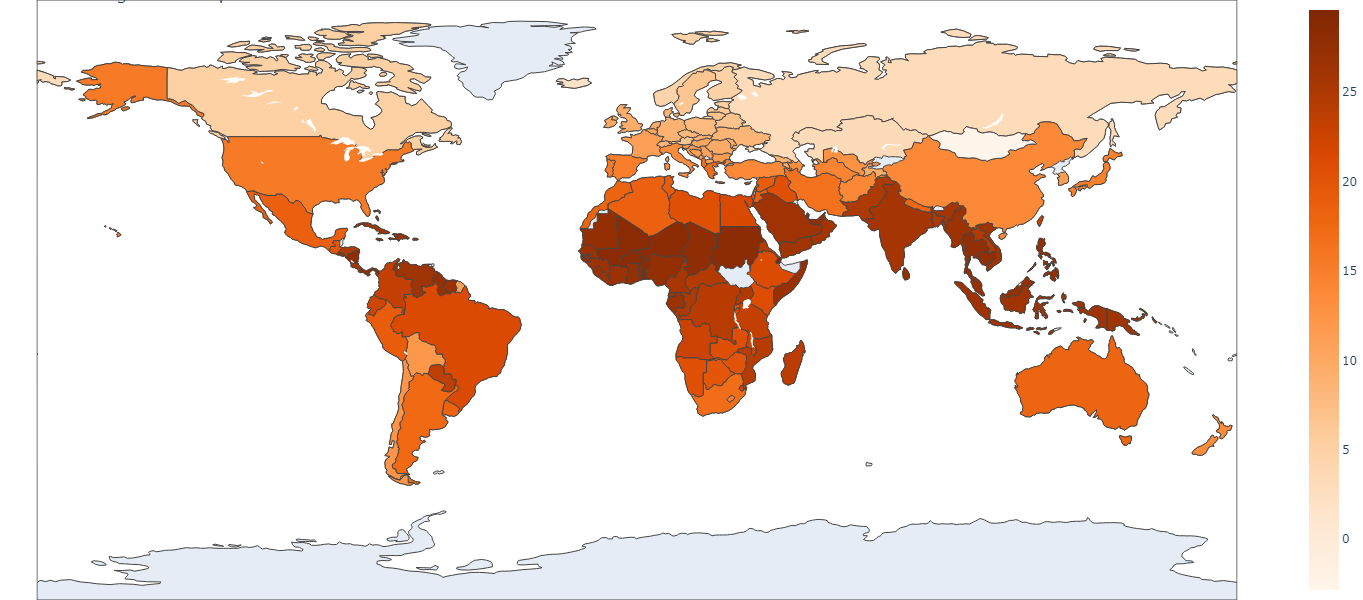

In [27]:
df_temp_predict = pd.read_csv('final_output/arima_model_output.csv')
# df_temp_predict[(df_temp_predict['Year'] == 2043)] 
df_mean_yr_pred = df_temp_predict[(df_temp_predict['Year'] == 2043)] 
data = [ dict(type = 'choropleth',
        locations = df_mean_yr_pred['Country'],
        z = df_mean_yr_pred['AverageTemperature'],
        locationmode = 'country names',
        text = df_mean_yr_pred['Country'],
        colorscale='oranges')]

layout = dict( title = 'Average land temperature in countries', geo = dict(projection = {'type' : 'equirectangular'} ), margin={"r":0,"t":0,"l":0,"b":0},width= 1400, height=600)
fig = pg.Figure(data=data, layout=layout)
fig.show()

# Data Preparation and Analyzation for Two Sub-Datasets <a id='TWOSUBDATA'></a>

In [28]:
df_co2_emission = pd.read_csv('source/CO2_emission.csv')
df_forest_area = pd.read_csv('source/forest-area-km.csv')

### Cleaning CO2 Dataset

In [29]:
df_co2_transpose = df_co2_emission.melt(id_vars=['Country Name','country_code','Region','Indicator Name'])
df_co2_transpose.drop(columns="Indicator Name",inplace = True)
df_co2_transpose_dropna = df_co2_transpose.dropna()
df_co2_transpose_dropna.rename(columns={'Country Name': 'Country', 'variable': 'year','value': 'co2_emission'}, inplace=True)
df_co2 = df_co2_transpose_dropna[df_co2_transpose_dropna.year != '2019.1']

df_co2

C:\Users\sachi\AppData\Local\Temp\ipykernel_33128\2205785686.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Country country_code                      Region  year  \
1              Afghanistan          AFG                  South Asia  1990   
2                   Angola          AGO          Sub-Saharan Africa  1990   
3                  Albania          ALB       Europe & Central Asia  1990   
4                  Andorra          AND       Europe & Central Asia  1990   
5     United Arab Emirates          ARE  Middle East & North Africa  1990   
...                    ...          ...                         ...   ...   
6445                 Samoa          WSM         East Asia & Pacific  2019   
6446           Yemen, Rep.          YEM  Middle East & North Africa  2019   
6447          South Africa          ZAF          Sub-Saharan Africa  2019   
6448                Zambia          ZMB          Sub-Saharan Africa  2019   
6449              Zimbabwe          ZWE          Sub-Saharan Africa  2019   

      co2_emission  
1         0.191745  
2         0.553662  
3         1.819542  
4         7.521832  
5        30.195189  
...            ...  
6445      1.522124  
6446      0.380633  
6447      7.507736  
6448      0.380717  
6449      0.802979  

[5704 rows x 5 columns]

### Analyzing the CO2 Data

<Axes: xlabel='Country', ylabel='co2_emission'>

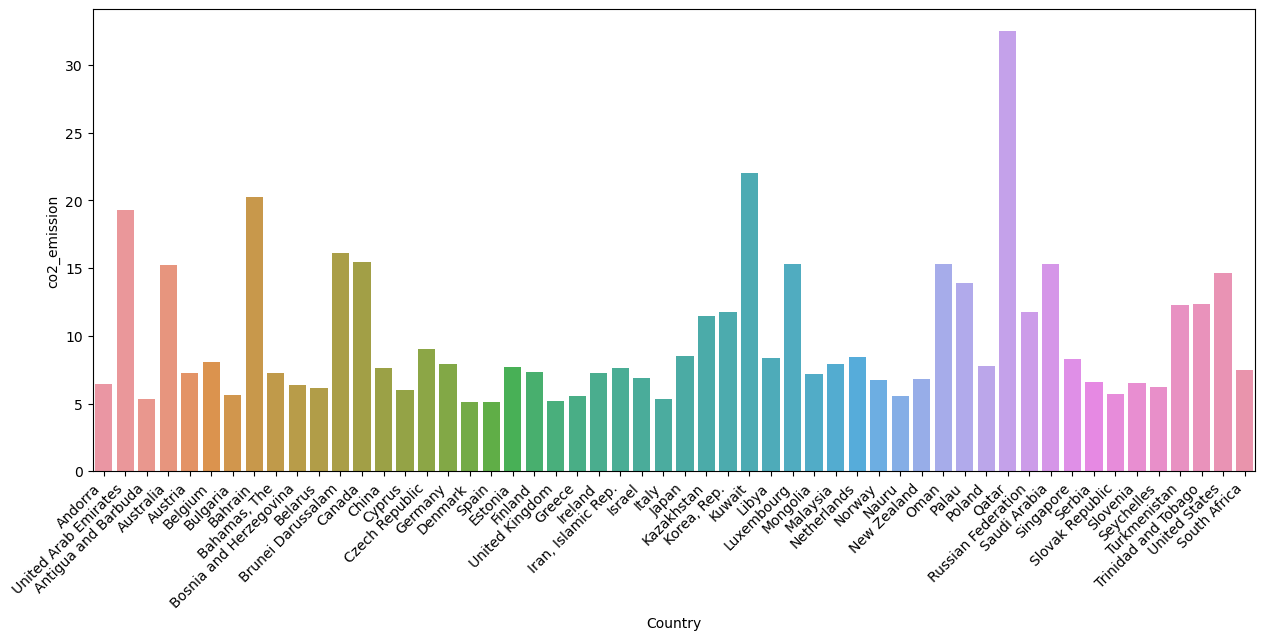

In [30]:
df_co2_1 = df_co2[(df_co2['year'] == '2019') & (df_co2['co2_emission'] > 5)][['Country','co2_emission']].reset_index().drop(columns = ['index'])
# df_co2_2 = df_co2[(df_co2['year'] == '2013') & (df_co2['co2_emission'] <= 7) & (df_co2['co2_emission'] > 3)][['Country','co2_emission']].reset_index().drop(columns = ['index'])
# df_co2_3 = df_co2[(df_co2['year'] == '2013') & (df_co2['co2_emission'] <= 3) & (df_co2['co2_emission'] > 0.5)][['Country','co2_emission']].reset_index().drop(columns = ['index'])
# df_co2_4 = df_co2[(df_co2['year'] == '2013') & (df_co2['co2_emission'] <= 0.5)][['Country','co2_emission']].reset_index().drop(columns = ['index'])
fig=plt.figure(figsize=(15,6))
plt.xticks(rotation=45, ha='right')
sns.barplot(x = df_co2_1['Country'], y = df_co2_1['co2_emission'])

# df_co2_plot = [np.array(df_co2_1), np.array(df_co2_2)]
# df_co2_plot = [df_co2_1, df_co2_2]
# , df_co2_3, df_co2_4

# countries = ['Australia','China','India','Japan', 'Mexico','Russia','United Kingdom', 'United States','South Africa','Saudi Arabia']
# fig=plt.figure(figsize=(10,6))
# for i in range(len(df_co2_plot)):
#     ax=fig.add_subplot(2,1,i+1)
#     plt.xticks(rotation=45, ha='right')
#     sns.barplot(x = df_co2_plot[i]['Country'], y = df_co2_plot[i]['co2_emission'])
#     # ax.set_title(country)
#     fig.tight_layout() 

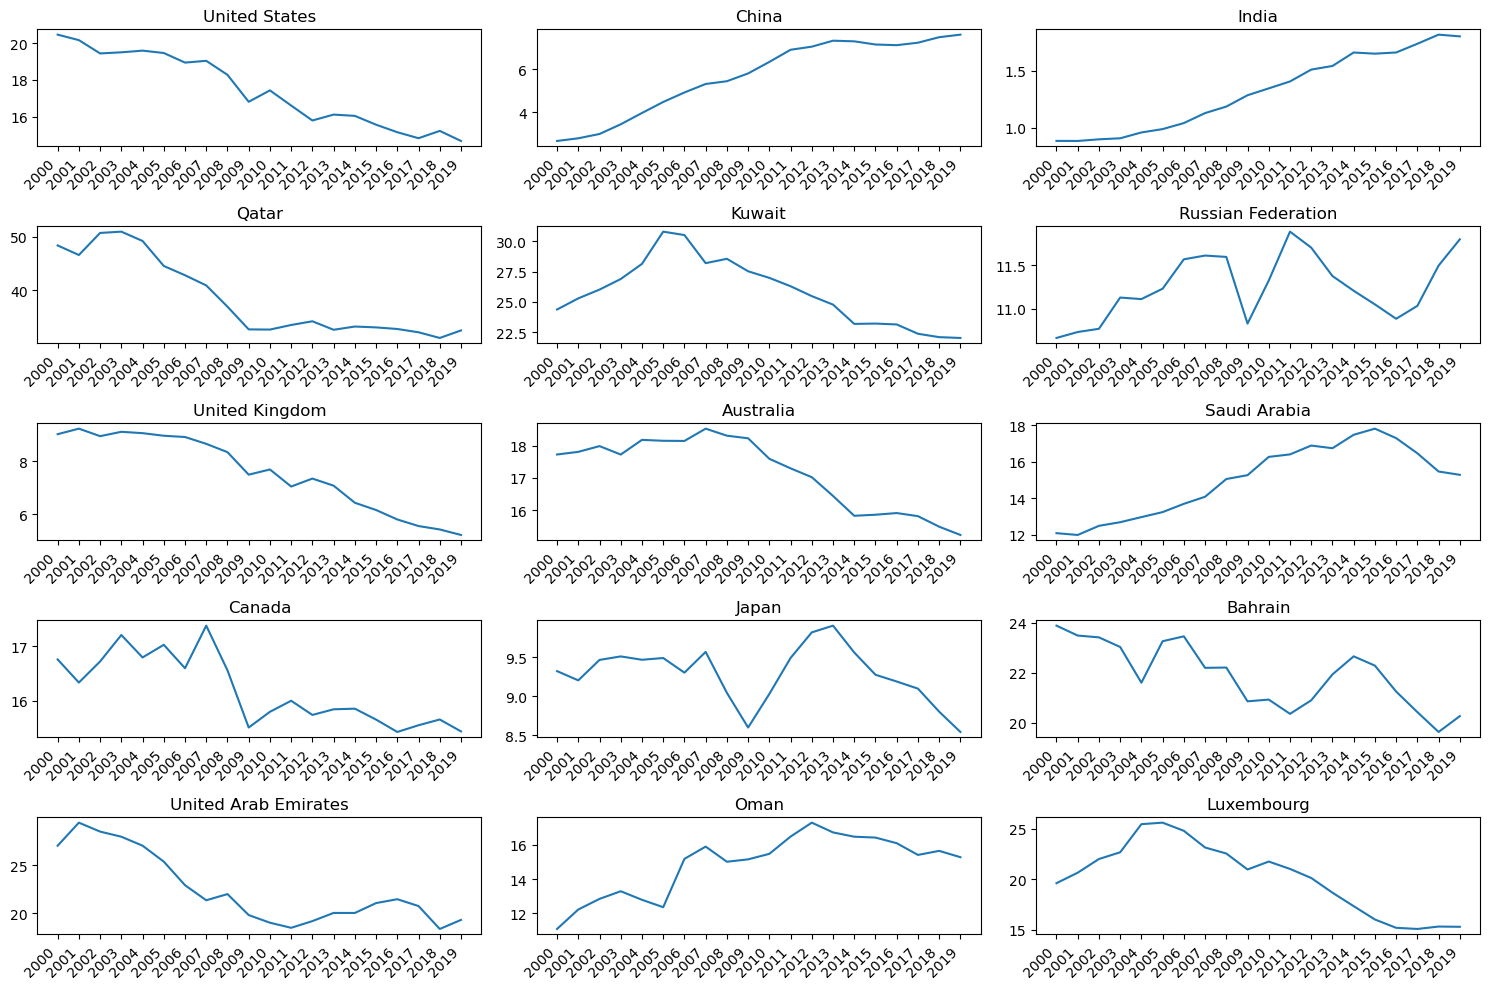

In [31]:
countries = ['United States','China','India','Qatar', 'Kuwait','Russian Federation','United Kingdom', 'Australia', 'Saudi Arabia', 'Canada', 
             'Japan', 'Bahrain','United Arab Emirates','Oman','Luxembourg']
fig=plt.figure(figsize=(15,10))
for i,val in enumerate(countries):
    df_co2_plot = df_co2[(df_co2['year'] >= '2000') & (df_co2['Country'] == val)][['year','co2_emission']].reset_index().drop(columns = ['index'])
    ax=fig.add_subplot(5,3,i+1)
    plt.xticks(rotation=45, ha='right')
    plt.plot(df_co2_plot['year'], df_co2_plot['co2_emission'])
    ax.set_title(val)
    fig.tight_layout() 

### Cleaning Forest Area Dataset

In [32]:
df_forest_nonNull = df_forest_area.dropna()
df_forest = df_forest_nonNull.rename(columns={'Entity': 'Country', 'Year': 'year','Code': 'country_code', 'Forest area': 'forest_area'})
# df_forest
# df_forest[(df_forest['year'] == 2019)][['Country','forest_area']].reset_index().drop(columns = ['index'])


### Analyzing Forest Area Dataset

<BarContainer object of 59 artists>

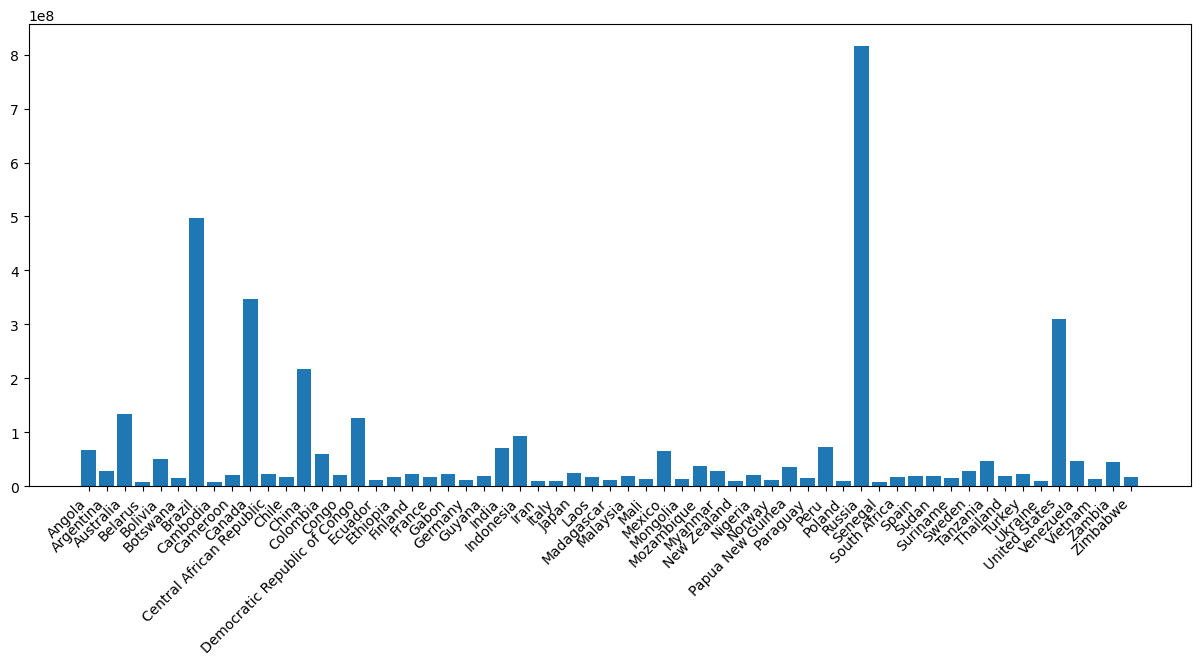

In [33]:
df_forest_1 = df_forest[(df_forest['year'] == 2019) & (df_forest['forest_area'] > 8000000) & (df_forest['Country'] != 'World')]\
[['Country','forest_area']].reset_index().drop(columns = ['index'])
#& (df_forest['co2_emission'] > 5)
fig=plt.figure(figsize=(15,6))
plt.xticks(rotation=45, ha='right')
plt.bar(df_forest_1['Country'], df_forest_1['forest_area'])

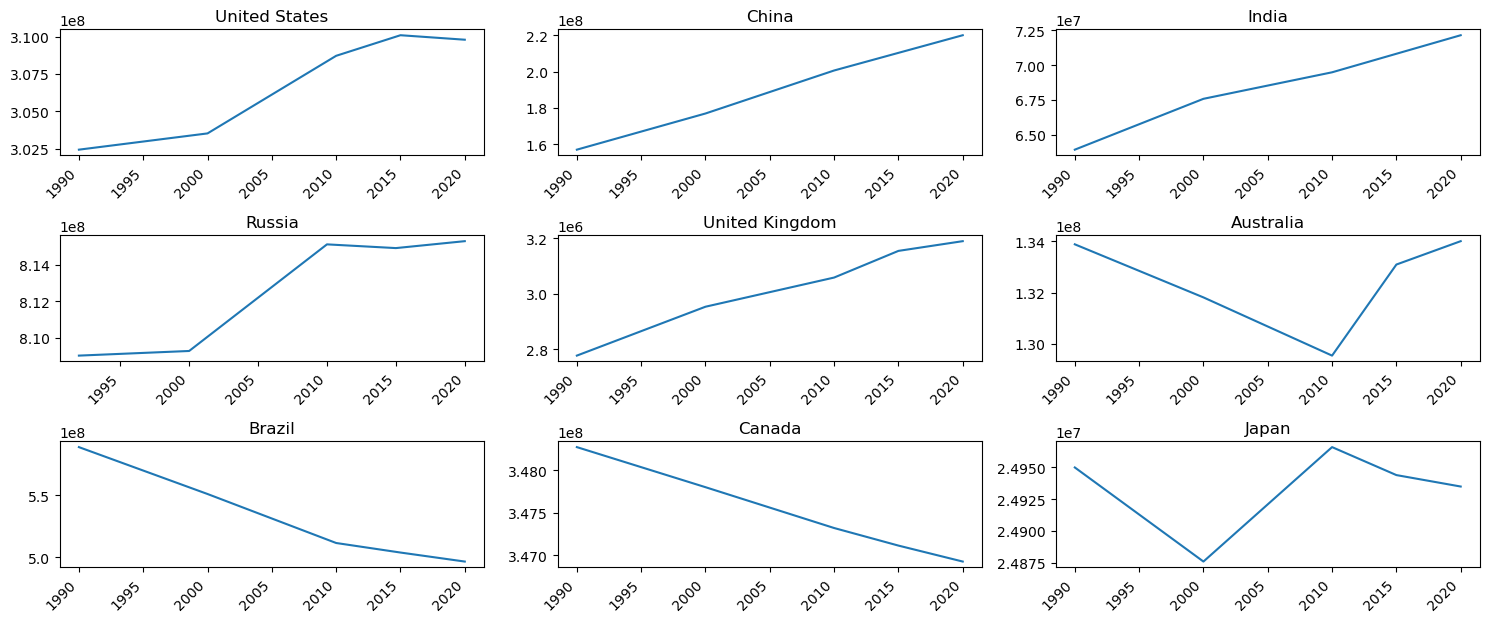

In [34]:
countries = ['United States','China','India', 'Russia','United Kingdom', 'Australia', 'Brazil', 'Canada', 'Japan']
fig=plt.figure(figsize=(15,10))
for i,val in enumerate(countries):
    df_forest_plot = df_forest[(df_forest['Country'] == val)][['year','forest_area']].reset_index().drop(columns = ['index'])
    ax=fig.add_subplot(5,3,i+1)
    plt.xticks(rotation=45, ha='right')
    plt.plot(df_forest_plot['year'], df_forest_plot['forest_area'])
    ax.set_title(val)
    fig.tight_layout() 

### Merge Data for Artificial Neural Networks Model

In [35]:
# Convert year to int
df_co2['year'] = df_co2['year'].astype(int)

# Merge CO2 and forest area dataset by year and country
df_co2_forest = pd.merge(df_co2,df_forest,on=['country_code','year'])

C:\Users\sachi\AppData\Local\Temp\ipykernel_33128\345082283.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
# Rename the country column
df_co2_forest.rename(columns= {'Country_y':'Country'}, inplace = True)

In [37]:
# Convert the year column to int
df_mean['year'] = df_mean.year.astype(int)

In [38]:
# Merging CO2 and Forest data to temperature data
df_merge = pd.merge(df_mean,df_co2_forest, on = ['year','Country'])

In [39]:
# Drop uneccessary columns
df_merge.drop(columns=['Country_x','country_code','Region'],inplace = True)

In [40]:
df_merge['year'] = df_merge.year.astype(str)
df_merge.dtypes

Country                object
year                   object
AverageTemperature    float64
co2_emission          float64
forest_area           float64
dtype: object

# Artificial Neural Networks <a id='ANN'></a>

In [41]:
#Set Variable value
EPOCHS = 150
BATCH_SIZE = 10
ACTIVATION = 'relu'
VERBOSE = 1

In [42]:
def AI_Neural_Networks():
    
    ## Create Model

    model = Sequential() #1
    model.add(Dense(128, activation=ACTIVATION, input_dim=2, name='first_hidden')) 
    model.add(Dropout(0.2))

    # second hidden layer.  Use relu
    model.add(Dense(64, activation = ACTIVATION, name='second_hidden'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='linear', name='output'))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae']) 

    #model.summary()
    return model
    

In [43]:
def neural_net(country, is_extreme):
    
    print("Running for " + country)
    
    df_merge_indv_bak = df_merge[df_merge['Country'] == country]
    df_merge_indv = df_merge[df_merge['Country'] == country]
    
    # Get Latest Temperature
    max_yr = df_merge_indv.groupby(['Country'])['year'].max()[0]
    max_temp_df = df_merge_indv[df_merge_indv['year'] == max_yr]
    max_temp_df.reset_index(inplace=True)
    latest_temp = max_temp_df['AverageTemperature'].loc[0]
    latest_co2 = max_temp_df['co2_emission'].loc[0]
    latest_forest = max_temp_df['forest_area'].loc[0]
    
    value = [0] * 4
    value[0] = country
    percentage_change_co2 = [5, 2, 1, 0, -1, -2, -5]
    percentage_change_forest = [1, 0.5, 0.25, 0, 0.25, -0.5, -1] 
    
    if is_extreme == 'Y':
        for ii in percentage_change_co2:            
            value[1] = ii
            for jj in percentage_change_forest:
                value[2] = jj
                
                dt_size = len(CO2_Forest_Resultset)
                CO2_Forest_Resultset.loc[dt_size] = ''
                
                CO2_Forest_Resultset['Country'].loc[dt_size] = value[0]
                CO2_Forest_Resultset['CO2_Percent_Change'].loc[dt_size] = value[1]
                CO2_Forest_Resultset['Forest_Area_Percent_Change'].loc[dt_size] = value[2]
                CO2_Forest_Resultset['Predicted_Avg_Temp'].loc[dt_size] = latest_temp
        return CO2_Forest_Resultset
            
    # Column for model
    df_merge_indv = df_merge_indv[['AverageTemperature','co2_emission','forest_area']]
    
    x = df_merge_indv[['co2_emission','forest_area']]
    y = df_merge_indv[['AverageTemperature']]
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 5)

    # scale val
    scale = StandardScaler()
    scale = scale.fit(x)
    # print(X_test)
    X_scaled = scale.transform(x)
    X_train_scaled = scale.transform(X_train)
    X_test_scaled = scale.transform(X_test)
    # print(X_test_scaled)

    model = AI_Neural_Networks()
    history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs = EPOCHS, verbose=0)

    pred = model.predict(X_scaled, verbose=0)
    train_pred = model.predict(X_train_scaled, verbose=0)
    test_pred = model.predict(X_test_scaled, verbose=0)
    # print(test_pred)

    if(country == 'United States'): 
        #Model evaluation
        
        plt.plot(history.history['mae'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.show()
        
        plt.plot(history.history['loss'])
        plt.title('Model Loss over Time')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.show()
        
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x['co2_emission'],x['forest_area'], y['AverageTemperature'],
                   linewidths=1, alpha=.7,
                   edgecolor='k',
                   s = 200, label = 'Actual')
        ax.scatter(x['co2_emission'],x['forest_area'], pred,
                   linewidths=1, alpha=.7,
                   edgecolor='k',
                   s = 200, label = 'Predicted')
        ax.set_xlabel('CO2 Emissions')
        ax.set_ylabel('Forest Area')
        ax.set_zlabel('Average Temperature')
        ax.legend()
        plt.show()

        train_mse = mean_squared_error(y_train,train_pred)
        test_mse =  mean_squared_error(pd.Series(y_test['AverageTemperature']),test_pred)

        train_r2 = r2_score(pd.Series(y_train['AverageTemperature']),train_pred)
        test_r2 =  r2_score(pd.Series(y_test['AverageTemperature']),test_pred)

        train_mape = mean_absolute_percentage_error(y_train['AverageTemperature'],train_pred)
        test_mape =  mean_absolute_percentage_error(pd.Series(y_test['AverageTemperature']),test_pred)

        print("MSE for Training Dataset :", train_mse)
        print("MSE for Test Dataset :", test_mse)
        print("R2 for Training Dataset :", train_r2)
        print("R2 for Test Dataset :", test_r2)
        print("MAPE for Training Dataset :", train_mape)
        print("MAPE for Test Dataset :", test_mape)
    
    for j in percentage_change_co2:
        value[1] = j
        percent_val_co2 = j * 0.01
        
        #Reset
        # df_merge_indv['co2_emission'] = df_merge_indv_bak['co2_emission']
        # df_merge_indv['co2_emission'] = df_merge_indv['co2_emission'] + (df_merge_indv['co2_emission'] * percent_val_co2)
        x_co2 = latest_co2 + (latest_co2 * percent_val_co2)
        
        for k in percentage_change_forest:
            value[2] = k
            percent_val_fr = k * 0.01
            
            #Reset
            # df_merge_indv['forest_area'] = df_merge_indv_bak['forest_area']
            # df_merge_indv['forest_area'] = df_merge_indv['forest_area'] + (df_merge_indv['forest_area'] * percent_val_fr)
            x_forest = latest_forest + (latest_forest * percent_val_fr)
            
            x_predict = [[x_co2,x_forest]]
            X_predict = pd.DataFrame(x_predict, columns=['co2_emission','forest_area'])
            
            X_predict_scaled = scale.transform(X_predict)
            y_predict = model.predict(X_predict_scaled, verbose=0)
            
            # np_tst = np.array(test_pred)
            # np_tst_mean = np_tst.mean()
            
            # value[3] = np_tst_mean
            # value[3] = y_pred
            
            # Add to df
            dt_size = len(CO2_Forest_Resultset)
            CO2_Forest_Resultset.loc[dt_size] = ''
            
            CO2_Forest_Resultset['Country'].loc[dt_size] = value[0]
            CO2_Forest_Resultset['CO2_Percent_Change'].loc[dt_size] = value[1]
            CO2_Forest_Resultset['Forest_Area_Percent_Change'].loc[dt_size] = value[2]
            if j == 0 and k == 0:
                CO2_Forest_Resultset['Predicted_Avg_Temp'].loc[dt_size] = latest_temp
            else:
                CO2_Forest_Resultset['Predicted_Avg_Temp'].loc[dt_size] = y_predict[0][0]
                
    return CO2_Forest_Resultset
    

<h3> Population Selection </h3>

In [44]:
# Countries that return incorrect temperature because of data issues like no or minor change in forest area. 
# Model prediction are completely off if we predict the impact with 1% change in forest area.
#So, We are removing these countries from prediction and showing their last available year temperature only for visualization.

extreme_country =   ['Mali'
                    ,'Turkmenistan'
                    ,'Saudi Arabia'
                    ,'Afghanistan'
                    ,'Bahamas'
                    ,'Yemen'
                    ,'Libya'
                    ,'Jordan'
                    ,'Lesotho'
                    ,'Djibouti'
                    ,'Oman'
                    ,'Gabon'
                    ,'Suriname'
                    ,'Guyana'
                    ,'Japan'
                    ,'Papua New Guinea'
                    ,'Congo'
                    ,'Norway'
                    ,'Sudan'
                    ,'Costa Rica'
                    ,'Venezuela']

In [45]:
#countries = [i for i in df_merge.Country.unique()]

In [46]:
countries = ["United States"]

<h3> Run the Model </h3>

Running for United States


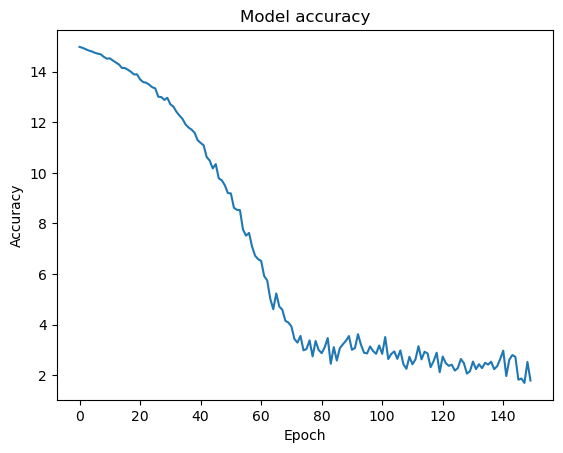

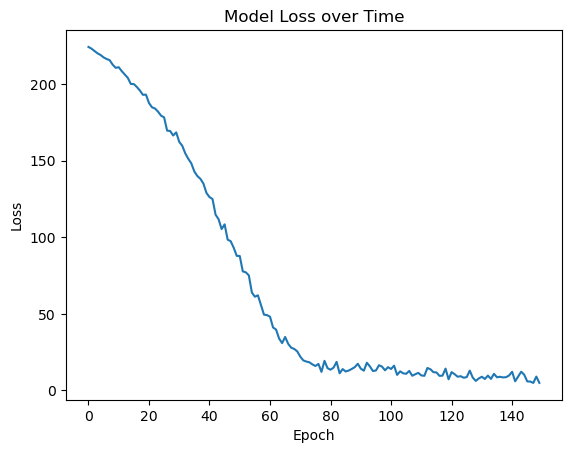

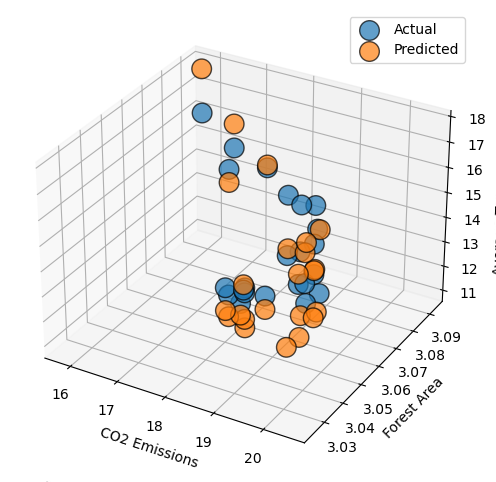

MSE for Training Dataset : 4.771487269781034
MSE for Test Dataset : 2.46618928296771
R2 for Training Dataset : -41.05254357171497
R2 for Test Dataset : -85.37214985831505
MAPE for Training Dataset : 0.11601395184184653
MAPE for Test Dataset : 0.08329032411592227


In [47]:
# dataframe that store output
CO2_Forest_Resultset = pd.DataFrame(columns = ['Country','CO2_Percent_Change', 'Forest_Area_Percent_Change','Predicted_Avg_Temp'])

for i in countries:
    if i in extreme_country:
        is_extreme = 'Y'
    else:
        is_extreme = 'N'
    
    CO2_Forest_Resultset = neural_net(i, is_extreme)
    

In [48]:
# Output the model to csv file
CO2_Forest_Resultset.to_csv('us_output/sample_neural_net_output_us.csv') 
#CO2_Forest_Resultset.to_csv('final_output/neural_net_output.csv') 